In [1]:
# !pip install Mastodon.py==1.8.0
# !pip install requests==2.25.1
# !pip install pandas==1.2.4
# !pip install textblob==0.17.1

# Python version 3.8.8

In [2]:
from mastodon import Mastodon, MastodonNotFoundError
import requests
from requests.auth import HTTPBasicAuth
import datetime as dt
import pandas as pd
import re
from io import StringIO
from html.parser import HTMLParser
from textblob import TextBlob

In [3]:
ADO_API_KEY = "a2a6e2f96a2c94a04661aacc6e394caa"
ADO_LOGIN_URL = "https://api.ado.eresearch.unimelb.edu.au/login"
ADO_TEXT_SEARCH_URL = 'https://api.ado.eresearch.unimelb.edu.au/analysis/textsearch/collections/mastodon'
MASTODON_KEY = "f8-yNpSEGxPcQwwz_GxYtET3VumoGZ6KAQAH6bybICE"

In [4]:
# Helper function for cleaning toots from HTML tags - may not be necessary when sending toots to CounchDB

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [5]:
# Login to ADO

res = requests.post(ADO_LOGIN_URL, auth=HTTPBasicAuth('apikey', ADO_API_KEY))
if res.ok:
    jwt = res.text

In [6]:
# Generate ADO query

text_kws = ['interest rate', ' rba', 'rba decision', "rba's decision", 
            'cash rate', 'interest payment', 'interest repayment', 'interest re-payment', 'repayment of interest', 
            'variable interest', 'fixed interest', 'bank interest', 'rate hike', 
            'mortgage', 'rent payment', 'house rent', 'houserent', 'house payment', 'housing', 
            'inflation', 'cpi index', 'cost of living', 'shrinkflation', 
            'social security', 'job seeker', 'jobseeker', 'youth allowance', 'austudy', 'centrelink', 'centerlink']
look_back_days = 7

today = dt.datetime.now().date()
text_kws = [f'text:"{kw}"' for kw in text_kws]
dates = [f"""date:\"{date.strftime('%Y%m%d')}\"""" for date in pd.date_range(today-dt.timedelta(days=look_back_days), today)]

query = '('+' OR '.join(text_kws) +') AND (' + ' OR '.join(dates) + ')'
#query = '('+' OR '.join(text_kws) +')'
#query

In [7]:
# Retrivie post ids - this takes around 1 min

qs_params = { 'query' : query}
headers = {'Authorization': f"Bearer {jwt}"}
res = requests.get(ADO_TEST_SEARCH_URL, headers = headers, params=qs_params)
result = res.json()

while True: #each API request returns 200 ids, need multiple requests in order to get all toots
    headers = {'Authorization': f"Bearer {jwt}", 'x-ado-bookmark':res.headers['x-ado-bookmark']}
    res = requests.get(ADO_TEXT_SEARCH_URL, headers = headers, params=qs_params)
    result_2 = res.json()
    if result_2 == []:
        break
    result.extend(result_2)


In [8]:
len(result)

1729

In [11]:
#Retrive toots from Mastodon API

sentiments = []

for line in result[:100]: #capping the number of toots to display (for now)
    id = line.split('/')
    try:
        #TO DO: REPLACE THE BELOW AND SEND THE DATA RO COUCHDB
        #print(f'\n{id}')
        toot = Mastodon(api_base_url=f'https://{id[0]}', 
                     access_token = MASTODON_KEY).status(id[2])['content']
        toot_clean = strip_tags(toot)
        print(toot_clean)
        sentiment = TextBlob(toot_clean).sentiment.polarity
        print("Sentiment: ",sentiment)
        sentiments.append(sentiment)
    except MastodonNotFoundError: #TO DO: REMOVE THIS EXCEPTION
        print('*** Post not found')
        continue
    except:
        print("Error getting the toot") #TO DO: REMOVE PRINT
        continue

*** Post not found
https://www.theguardian.com/australia-news/2023/may/09/federal-budget-2023-welfare-cost-of-living-crisis-relief-plan-jobseeker-youth-allowance-increase-rent-assistance-affordable-housing-australiaJim Chalmers concedes some Australians want the government to do more to help those struggling to pay rent and bills.
Sentiment:  0.5
Interest Rate Hikes Are Drowning Us in Debt Today's interest rate hike will force millions of households to borrow just to make ends meet, doing nothing to curb inflation caused by the rich. We need a debt write off to escape the cost of living crisishttps://tribunemag.co.uk/2023/05/interest-rate-hikes-are-drowning-us-in-debt/
Sentiment:  0.375
https://www.abc.net.au/news/2023-05-10/budget-2023-centrelink-rent-austudy-jobseeker-changes-explained/102324484#amp_tf=From%20%251%24s&aoh=16836839073062&csi=0&referrer=https%3A%2F%2Fwww.google.com&ampshare=https%3A%2F%2Fwww.abc.net.au%2Fnews%2F2023-05-10%2Fbudget-2023-centrelink-rent-austudy-jobseeker

https://finance.yahoo.com/news/cpi-preview-inflation-expected-to-remain-elevated-in-april-as-rate-hike-risks-loom-144811803.htmlInvestors will turn their attention to critical data that will help determine the future of Federal Reserve policy: the April inflation report.
Sentiment:  0.0
Budget lifts JobSeeker and welfare payments as Labor posts a surplushttps://www.abc.net.au/news/2023-05-09/federal-budget-2023-2024-jim-cost-of-living-support-surplus/102316578
Sentiment:  0.0
Argentina plans new rate hike, more FX intervention as inflation soars http://reut.rs/42MsjGc  #press
Sentiment:  0.3181818181818182
Feel like you're paying more for less? These are the latest items to be hit by 'shrinkflation' https://www.sbs.com.au/news/article/feel-like-youre-paying-more-for-less-these-are-the-latest-items-to-be-hit-by-shrinkflation/1x4h4ac1l #Australia
Sentiment:  0.2777777777777778
Well no surprises in the budget, Newstart payments increased by a whopping $2.85 a day also known as enough to b

www.telegraph.co.uk for the latest news from the UK and around the world. | Eurozone inflation will get even worse, warns EU - latest updateshttps://www.telegraph.co.uk/business/2023/05/15/ftse-100-markets-live-news-brexit-inflation-nfu/#WNN7 #BreakingNews #WorldNewsNuggets
Sentiment:  0.19999999999999998
These coins are designed to protect stablecoin holders from inflation. But they are complicated and it’s not clear whether they will actually work.Read more: https://trib.al/dKTEQFH  #press
Sentiment:  -0.012500000000000011
Just had my local National Party electorate candidate come and knock on our door. Given the time of day/week, I'd imagine he's not looking spend much time talking to students, professionals, or anyone picking up their kids from school.Did seem awfully concerned about mortgage costs, bless his heart.
Sentiment:  -0.26666666666666666
By allowing denser housing along public-transit corridors, Lexington, Massachusetts, is responding to the crises of housing affordabili

www.telegraph.co.uk for the latest news from the UK and around the world. | 'It's a disaster': Inside the growing Tory revolt over Michael Gove's war on landlordshttps://www.telegraph.co.uk/property/buy-to-let/michael-gove-war-on-landlords-buy-to-let-housing-crisis/#WNN7 #BreakingNews #WorldNewsNuggets
Sentiment:  0.5
Dollar hits 5-week high on inflation worries; lira drops, baht soars http://reut.rs/3o1gjSd  #press
Sentiment:  0.16
I do not expect to be successful during my lifetime. Not in the capitalistic bullshit American Dream sense. I didn't win the birth lottery, so it's pretty much not in the cards for me. And that is fine.I am sure I will be posthumously successful. In that regard. I'll probably make my fortune after I have died. I plan to live for as long as possible...but I like to think that after I die there will be a somewhat substantial sum of funds derived from the sale of my work. And if that happens, and if Austin outlives me the way that I really hope he does, I want

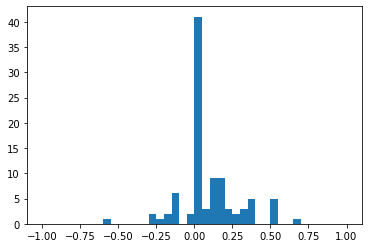

In [13]:
from matplotlib import pyplot as plt
plt.hist(sentiments, bins=40, range=(-1,1))
plt.show()